## 予備実験1までのnotebook

In [1]:
import glob
import os
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

In [2]:
# data/result/に格納されている全csvファイルの読み込み
csv_files = glob.glob(os.path.join("../../data/result", "*.csv"))
df_list = []
for file in csv_files:
    tmp_df = pd.read_csv(file)
    df_list.append(tmp_df)
df = pd.concat(df_list, ignore_index=True)

In [3]:
# predの要素で, propertyが含まれる値を返す
df_prop = df.query('pred.str.contains("property")', engine='python').dropna()

# 'wikiPage'を含まないpropertyを返す
df_prop = df_prop[~df_prop['pred'].str.contains('wikiPage')]
# '画像'を含まないpropertyを返す
df_prop = df_prop[~df_prop['pred'].str.contains('画像')]

In [4]:
# モデル読み込み
model = Word2Vec.load('../../Models/japanese-word2vec-model-builder/word2vec.gensim.model')

In [5]:
# モデルを利用した文字のエンべディング
## 未知語に関しては, 今回はNaNで対応
def vectorize(model, word):
    try:
        output = model.wv[word]
        return output
    except:
        return np.nan

In [6]:
# obj要素に関してはLOD同士が繋がっているため, 基本的にURIで記述されている.
# また, (県の魚:〇〇)の要素や数値データが入っている場合もあるため, それぞれ最後尾の要素を値として扱う. 
def preprocessing(obj):
    if type(obj) != str:
        output = obj
    elif len(obj.split("：")) != 1:
        output = obj.split("：")[-1]
    else:
        output = obj.split("/")[-1]
    return output

In [7]:
# vectorization
## key要素(本データでは〇〇県)は,単純エンベディング対象.
## obj要素は, 上記の関数で整えた後に, エンベディング.
cp_df_prop = df_prop.copy()
cp_df_prop['key_vec'] = cp_df_prop['key'].map(lambda x:vectorize(model,x))
cp_df_prop['label'] = cp_df_prop['pred']
obj_list = cp_df_prop['obj'].map(lambda x:preprocessing(x))
cp_df_prop['obj_vec'] = obj_list.map(lambda x:vectorize(model,x))

In [8]:
# ベクトル化前のデータとベクトル化後のデータの結合 + 未知語のNaNの排除
df_vec = pd.merge(df_prop, cp_df_prop, left_index=True, right_on=df_prop.index)
df_vec = df_vec.reset_index(drop=True)
df_vec = df_vec.drop(["key_0","key_y","pred_y","obj_y"], axis=1)
df_vec = df_vec.dropna().reset_index(drop=True)

In [9]:
top_10_df_prop = df_vec.groupby('pred_x').count().sort_values(['obj_x'], ascending=False).head(10)
top_10_prop_list = top_10_df_prop.index.to_list()

# 頻出上位10を持つdataの抽出
top_10_df = df_vec[df_vec['pred_x'].isin(top_10_prop_list)]
top_10_df = top_10_df.reset_index(drop=True)

# predを目的変数(label)として扱うための準備
prop_to_label = dict(zip(top_10_prop_list, range(0,10)))
column_name = dict(map(lambda k: (k[1],k[0].split("/")[-1]), prop_to_label.items()))

In [60]:
top_10_df[top_10_df['key_x'] == '東京都']

,key_x,pred_x,obj_x,key_vec,label,obj_vec
51,東京都,http://ja.dbpedia.org/property/before,http://ja.dbpedia.org/resource/東京市,"[0.1542314, 0.0170629, 0.018456174, -0.0464775...",http://ja.dbpedia.org/property/before,"[0.14468665, 0.19433145, -0.04068601, 0.107723..."
52,東京都,http://ja.dbpedia.org/property/before,http://ja.dbpedia.org/resource/東京府,"[0.1542314, 0.0170629, 0.018456174, -0.0464775...",http://ja.dbpedia.org/property/before,"[0.16848555, 0.09644124, 0.006623271, 0.145266..."
53,東京都,http://ja.dbpedia.org/property/name,東京都,"[0.1542314, 0.0170629, 0.018456174, -0.0464775...",http://ja.dbpedia.org/property/name,"[0.1542314, 0.0170629, 0.018456174, -0.0464775..."
54,東京都,http://ja.dbpedia.org/property/years,1868,"[0.1542314, 0.0170629, 0.018456174, -0.0464775...",http://ja.dbpedia.org/property/years,"[-0.17045037, 0.12737018, -0.116660655, 0.0062..."
55,東京都,http://ja.dbpedia.org/property/years,1943,"[0.1542314, 0.0170629, 0.018456174, -0.0464775...",http://ja.dbpedia.org/property/years,"[-0.060786586, 0.048954207, -0.2149796, -0.008..."
56,東京都,http://ja.dbpedia.org/property/所在地,220,"[0.1542314, 0.0170629, 0.018456174, -0.0464775...",http://ja.dbpedia.org/property/所在地,"[-0.09050962, -0.045152023, -0.16325991, 0.036..."
57,東京都,http://ja.dbpedia.org/property/所在地,東京都庁舎,"[0.1542314, 0.0170629, 0.018456174, -0.0464775...",http://ja.dbpedia.org/property/所在地,"[0.07401823, 0.16210052, 0.031065175, 0.078788..."
58,東京都,http://ja.dbpedia.org/property/説明,http://ja.dbpedia.org/resource/山手線,"[0.1542314, 0.0170629, 0.018456174, -0.0464775...",http://ja.dbpedia.org/property/説明,"[0.0438686, 0.31492886, -0.17156677, -0.131939..."
59,東京都,http://ja.dbpedia.org/property/説明,http://ja.dbpedia.org/resource/新宿,"[0.1542314, 0.0170629, 0.018456174, -0.0464775...",http://ja.dbpedia.org/property/説明,"[0.28044704, 0.014530917, -0.10405843, -0.1517..."
60,東京都,http://ja.dbpedia.org/property/説明,http://ja.dbpedia.org/resource/東京駅,"[0.1542314, 0.0170629, 0.018456174, -0.0464775...",http://ja.dbpedia.org/property/説明,"[0.04835558, 0.21803294, -0.20054531, -0.14696..."


In [11]:
# 目的変数のバイナライズ + 説明変数の切り出し
lb = LabelBinarizer()
lb.fit(top_10_df.label)
label_dence = lb.fit_transform(top_10_df.label)
input_data = list(top_10_df['obj_vec'].values)
#X_train, X_test, y_train, y_test = train_test_split(input_data, label_dence)

In [12]:
# マルチラベル分類
forest = RandomForestClassifier(n_estimators = 500, random_state=1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
multi_target_forest.fit(input_data, label_dence)

MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=500,
                                                       random_state=1),
                      n_jobs=-1)

In [13]:
estimator = multi_target_forest.estimators_
y_pred = multi_target_forest.predict(input_data)
y_pred_proba = multi_target_forest.predict_proba(input_data)

In [14]:
list(column_name.values())

['隣接都道府県', '表記', 'before', '説明', 'years', '所在地', '都道府県名', '郵便番号', 'name', '区分']

In [15]:
file_name = 'tree.png'
dot_data = export_graphviz(estimator[1][1],
                class_names=list(column_name.values()), 
                filled=True, 
                rounded=True)

graph = graph_from_dot_data( dot_data )

graph.write_png(file_name)

True

In [16]:
## 一応のclassification_report
# cl_report = classification_report(label_dence, y_pred)
# print(cl_report)

In [17]:
np_pred = np.array(y_pred)
np_proba = np.array(y_pred_proba)
np_proba_trans = np_proba.transpose(1,0,2)

In [49]:
print(y_pred[:100])

[[1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0

In [18]:
# ラベル有の閾値の設定
pred_0 = (np_proba_trans[:,:,1] > 0.0).astype(int)
pred_1 = (np_proba_trans[:,:,1] > 0.1).astype(int)
pred_2 = (np_proba_trans[:,:,1] > 0.2).astype(int)
pred_3 = (np_proba_trans[:,:,1] > 0.3).astype(int)

In [19]:
df = pd.DataFrame(np_pred)
df_0 = pd.DataFrame(pred_0)
df_1 = pd.DataFrame(pred_1)
df_2 = pd.DataFrame(pred_2)
df_3 = pd.DataFrame(pred_3)

df_1_new = df_1.rename(columns=column_name)
df_2_new = df_2.rename(columns=column_name)
df_3_new = df_3.rename(columns=column_name)

In [20]:
df_2_new

## 多ラベルの結果を教師データにして収束するかの実験
## 出来なかったら, cluster

,隣接都道府県,表記,before,説明,years,所在地,都道府県名,郵便番号,name,区分
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
736,0,0,0,0,0,0,0,0,0,1
737,0,0,0,1,0,0,0,0,0,0
738,0,0,0,0,0,0,0,0,0,1
739,0,0,0,0,0,0,0,0,0,1


<AxesSubplot:title={'center':'hoge'}>

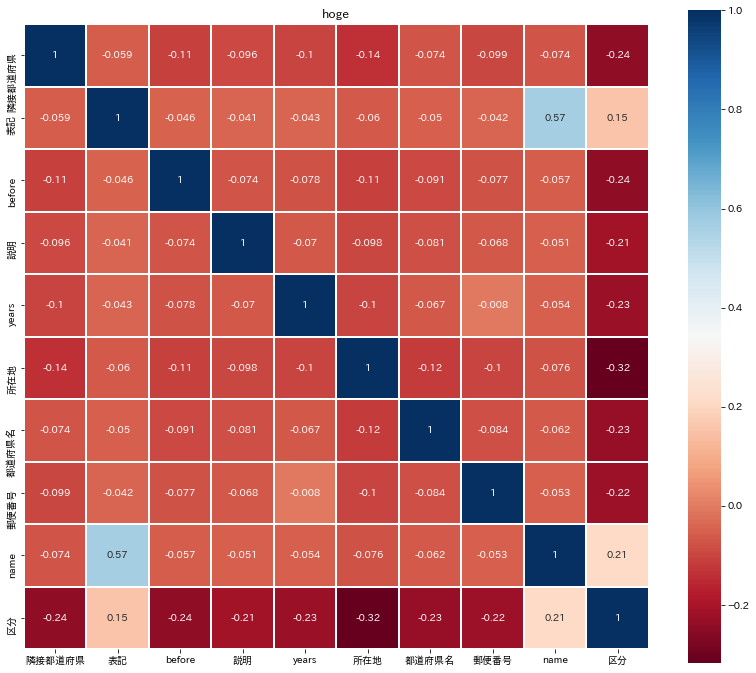

In [21]:
# 相関系の考察

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('hoge')
sns.heatmap(df_2_new.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [22]:
# 要素数の頻度
# Value_count の出力方法をライブラリ見る. 
    ## indexでラベル表示を確認すると, 0が隠れているのが見えた。

# df_3.value_counts().index

In [24]:
df_pre_obj = top_10_df.loc[:,['pred_x','obj_x']]
df_1_pre_obj = pd.concat([df_pre_obj,df_1_new],axis=1)
df_2_pre_obj = pd.concat([df_pre_obj,df_2_new],axis=1)
df_3_pre_obj = pd.concat([df_pre_obj,df_3_new],axis=1)

In [25]:
# df_2_pre_obj[df_2_pre_obj['シンボル名'] == 1]

In [26]:
# df_2_pre_obj[df_2_pre_obj['歌など'] == 1]

In [27]:
# df_2_pre_obj[df_2_pre_obj['説明'] == 1]

In [28]:
# df_2_pre_obj[df_2_pre_obj['title'] == 1]

In [29]:
# 共起系の考察
# pd.crosstab(df_2_pre_obj['歌など'], df_2_pre_obj['シンボル名'])

In [30]:
# pd.crosstab(df_2_pre_obj['説明'], df_2_pre_obj['title'])

In [31]:
# 教師データと分類結果の比較.
## 未知データを分類したきの相関.

## Randomforestのドキュメントあkら(シングル or マルチのタスクを調べる)

- *多クラス分類とは*
    - 2つ以上のクラス()

In [32]:
column_name

{0: '隣接都道府県',
 1: '表記',
 2: 'before',
 3: '説明',
 4: 'years',
 5: '所在地',
 6: '都道府県名',
 7: '郵便番号',
 8: 'name',
 9: '区分'}

In [33]:
# 教師データと分類結果の比較
y_pred_df = pd.DataFrame({'pred': lb.inverse_transform(y_pred)})
top_10_df_pred = pd.concat([top_10_df,y_pred_df],axis=1)

In [34]:
# before/afterの要素は行政区の変遷を示すが, 年代や順序などの要素はバラバラである.
# before/afterの多数の要素が隣接都道府県ラベルで予測されている理由としては, 隣接している都道府県の行政区であったため.
# そもそも歌など
fail_pred_df = top_10_df_pred[top_10_df_pred['label'] != top_10_df_pred['pred']]
fail_pre_index = list(fail_pred_df.index)
fail_pred_df

,key_x,pred_x,obj_x,key_vec,label,obj_vec,pred
3,沖縄県,http://ja.dbpedia.org/property/name,沖縄県,"[0.03427477, 0.17860307, -0.041606415, 0.09745...",http://ja.dbpedia.org/property/name,"[0.03427477, 0.17860307, -0.041606415, 0.09745...",http://ja.dbpedia.org/property/before
10,沖縄県,http://ja.dbpedia.org/property/都道府県名,沖縄県,"[0.03427477, 0.17860307, -0.041606415, 0.09745...",http://ja.dbpedia.org/property/都道府県名,"[0.03427477, 0.17860307, -0.041606415, 0.09745...",http://ja.dbpedia.org/property/before
13,佐賀県,http://ja.dbpedia.org/property/name,佐賀県,"[0.07099846, 0.12268844, 0.072164424, 0.127799...",http://ja.dbpedia.org/property/name,"[0.07099846, 0.12268844, 0.072164424, 0.127799...",http://ja.dbpedia.org/property/before
20,佐賀県,http://ja.dbpedia.org/property/都道府県名,佐賀県,"[0.07099846, 0.12268844, 0.072164424, 0.127799...",http://ja.dbpedia.org/property/都道府県名,"[0.07099846, 0.12268844, 0.072164424, 0.127799...",http://ja.dbpedia.org/property/before
26,徳島県,http://ja.dbpedia.org/property/name,徳島県,"[0.013457059, 0.049274415, 0.034320407, 0.1147...",http://ja.dbpedia.org/property/name,"[0.013457059, 0.049274415, 0.034320407, 0.1147...",http://ja.dbpedia.org/property/隣接都道府県
...,...,...,...,...,...,...,...
716,大分県,http://ja.dbpedia.org/property/name,大分県,"[0.01619406, 0.14829713, 0.05118972, 0.1368117...",http://ja.dbpedia.org/property/name,"[0.01619406, 0.14829713, 0.05118972, 0.1368117...",http://ja.dbpedia.org/property/隣接都道府県
722,大分県,http://ja.dbpedia.org/property/都道府県名,大分県,"[0.01619406, 0.14829713, 0.05118972, 0.1368117...",http://ja.dbpedia.org/property/都道府県名,"[0.01619406, 0.14829713, 0.05118972, 0.1368117...",http://ja.dbpedia.org/property/隣接都道府県
729,大分県,http://ja.dbpedia.org/property/隣接都道府県,http://ja.dbpedia.org/resource/高知県,"[0.01619406, 0.14829713, 0.05118972, 0.1368117...",http://ja.dbpedia.org/property/隣接都道府県,"[-0.021919195, 0.10427152, 0.04427553, 0.12341...",http://ja.dbpedia.org/property/before
730,高知県,http://ja.dbpedia.org/property/name,高知県,"[-0.021919195, 0.10427152, 0.04427553, 0.12341...",http://ja.dbpedia.org/property/name,"[-0.021919195, 0.10427152, 0.04427553, 0.12341...",http://ja.dbpedia.org/property/before


In [35]:
# 閾値を設けたマルチラベル分類とも比較してみた.
df_2_pre_obj.loc[fail_pre_index]

,pred_x,obj_x,隣接都道府県,表記,before,説明,years,所在地,都道府県名,郵便番号,name,区分
3,http://ja.dbpedia.org/property/name,沖縄県,0,1,0,0,0,0,0,0,1,0
10,http://ja.dbpedia.org/property/都道府県名,沖縄県,0,1,0,0,0,0,0,0,1,0
13,http://ja.dbpedia.org/property/name,佐賀県,0,1,0,0,0,0,0,0,1,1
20,http://ja.dbpedia.org/property/都道府県名,佐賀県,0,1,0,0,0,0,0,0,1,1
26,http://ja.dbpedia.org/property/name,徳島県,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
716,http://ja.dbpedia.org/property/name,大分県,0,0,0,0,0,0,0,0,0,1
722,http://ja.dbpedia.org/property/都道府県名,大分県,0,0,0,0,0,0,0,0,0,1
729,http://ja.dbpedia.org/property/隣接都道府県,http://ja.dbpedia.org/resource/高知県,0,0,0,0,0,0,0,0,0,1
730,http://ja.dbpedia.org/property/name,高知県,0,0,0,0,0,0,0,0,0,1
